<a href="https://colab.research.google.com/github/Hanbin-git/Dacon_cacer/blob/main/20250724_shap%EC%A0%84%EB%9E%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -o "/content/drive/MyDrive/data.zip" -d "/content/data_1"

Archive:  /content/drive/MyDrive/data.zip
  inflating: /content/data_1/sample_submission.csv  
  inflating: /content/data_1/test.csv  
  inflating: /content/data_1/train.csv  


In [ ]:
# ==============================================================================
# ✅ 초기 환경 설정 및 라이브러리 설치 (가장 먼저 실행)
# ==============================================================================

# 1. pip 캐시를 모두 비웁니다.
print("Clearing pip cache...")
!pip cache purge

# 2. numpy와 scikit-learn 관련 패키지를 강제로 제거합니다.
print("Uninstalling numpy and scikit-learn related packages...")
!pip freeze | grep -E 'numpy|scikit-learn' | xargs -n 1 pip uninstall -y

# 3. Colab 기본 라이브러리 (TensorFlow, Numba 등)와 호환되는 특정 버전의 numpy와 scikit-learn을 설치합니다.
#    numpy를 1.26.x 대로 낮춰서 시도합니다.
print("Installing compatible versions of numpy and scikit-learn (attempting numpy 1.26.x)...")
!pip install numpy==1.26.4 scikit-learn==1.6.0 --no-cache-dir --quiet

# 4. 나머지 필요한 라이브러리들을 설치합니다.
print("Installing other necessary libraries...")
!pip install rdkit-pypi catboost xgboost lightgbm optuna --no-cache-dir --quiet

# 5. 파이썬 런타임을 강제로 재시작합니다. (가장 중요!)
print("Forcing runtime restart... Please wait a few seconds for reconnection.")
import os
os.kill(os.getpid(), 9)

# ==============================================================================

Clearing pip cache...
Files removed: 0
Uninstalling numpy and scikit-learn related packages...
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Installing compatible versions of numpy and scikit-learn (attempting numpy 1.26.x)...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 349.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 210.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<

In [1]:
# numpy & scikit-learn 호환성 보장 버전으로 재설치
!pip install numpy==1.26.4 scikit-learn==1.5.0 --force-reinstall --quiet --no-cache-dir


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 307.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 221.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 334.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 321.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.0 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 whic

In [2]:
!pip install rdkit-pypi catboost xgboost lightgbm optuna --quiet --no-cache-dir


In [ ]:
import os
os.kill(os.getpid(), 9)


In [1]:
# ✅ 1. 라이브러리
import pandas as pd, numpy as np, optuna, time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, MACCSkeys, Lipinski
from catboost import CatBoostRegressor, Pool
import warnings
warnings.filterwarnings("ignore")

# ✅ 2. 데이터 경로 설정 (Colab)
train_path = "/content/data_1/train.csv"
test_path = "/content/data_1/test.csv"
submission_path = "/content/data_1/sample_submission.csv"

# ✅ 3. 데이터 로딩
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

# ✅ 4. SMILES → Mol 변환
train["Mol"] = train["Canonical_Smiles"].apply(Chem.MolFromSmiles)
test["Mol"] = test["Canonical_Smiles"].apply(Chem.MolFromSmiles)

# ✅ 5. Feature 생성 함수 (RDKit + Fingerprint)
def get_features(df):
    features = []
    for mol in df["Mol"]:
        if mol is None:
            features.append(np.zeros(2048 + 10))
            continue
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        descs = [
            Descriptors.MolWt(mol),
            Descriptors.MolLogP(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.TPSA(mol),
            Descriptors.NumRotatableBonds(mol),
            Descriptors.RingCount(mol),
            Lipinski.NumAromaticRings(mol),
            Lipinski.NumAliphaticRings(mol),
            Lipinski.NumSaturatedRings(mol),
        ]
        features.append(np.concatenate([fp, descs]))
    return pd.DataFrame(features)

X = get_features(train)
X_test = get_features(test)
y = train["Inhibition"]

# ✅ 6. Optuna 튜닝 Objective
def objective(trial):
    params = {
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "iterations": 3000,
        "task_type": "GPU",
        "devices": "0",
        "verbose": 0,
        "early_stopping_rounds": 50
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    maes = []
    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
        preds = model.predict(X_valid)
        mae = mean_absolute_error(y_valid, preds)
        maes.append(mae)

    return np.mean(maes)

# ✅ 7. Optuna 튜닝 수행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print("✅ Best Params:", study.best_params)

# ✅ 8. 최적 파라미터로 전체 학습
best_params = study.best_params
best_params.update({
    "iterations": 3000,
    "task_type": "GPU",
    "devices": "0",
    "early_stopping_rounds": 50,
    "verbose": 500
})

final_model = CatBoostRegressor(**best_params)
final_model.fit(X, y)

# ✅ 9. 예측 및 제출
preds = final_model.predict(X_test)
submission["Inhibition"] = preds
submission.to_csv("submission_catboost_optuna.csv", index=False)
print("✅ 제출 파일 저장 완료: submission_catboost_optuna.csv")


[I 2025-07-24 00:27:59,607] A new study created in memory with name: no-name-22f289ce-d8e0-4afe-aead-b4500a19d4a1
[I 2025-07-24 00:28:23,738] Trial 0 finished with value: 19.848299539685012 and parameters: {'depth': 10, 'learning_rate': 0.16941918122839386, 'l2_leaf_reg': 6.679162970668696, 'bagging_temperature': 0.03946037037149386, 'random_strength': 7.516664402127794}. Best is trial 0 with value: 19.848299539685012.
[I 2025-07-24 00:28:36,897] Trial 1 finished with value: 19.78045688863532 and parameters: {'depth': 5, 'learning_rate': 0.0666383385660528, 'l2_leaf_reg': 6.531849169898688, 'bagging_temperature': 0.33896922882559577, 'random_strength': 3.3643060129438322}. Best is trial 1 with value: 19.78045688863532.
[I 2025-07-24 00:28:49,823] Trial 2 finished with value: 19.858360940764676 and parameters: {'depth': 5, 'learning_rate': 0.05870742230548659, 'l2_leaf_reg': 2.4663907758442742, 'bagging_temperature': 0.5741414513157761, 'random_strength': 4.095244228038913}. Best is tri

✅ Best Params: {'depth': 5, 'learning_rate': 0.10241282624747099, 'l2_leaf_reg': 6.490954192088343, 'bagging_temperature': 0.8175774635077507, 'random_strength': 3.844677040758154}
0:	learn: 26.0862837	total: 6.28ms	remaining: 18.8s
500:	learn: 16.6861759	total: 2.7s	remaining: 13.5s
1000:	learn: 13.9339702	total: 5.44s	remaining: 10.9s
1500:	learn: 12.0522049	total: 8.12s	remaining: 8.11s
2000:	learn: 10.5858835	total: 10.8s	remaining: 5.4s
2500:	learn: 9.4968768	total: 13.5s	remaining: 2.69s
2999:	learn: 8.7179855	total: 16.2s	remaining: 0us
✅ 제출 파일 저장 완료: submission_catboost_optuna.csv


In [1]:
# ✅ 1. 기본 모듈
import pandas as pd, numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, MACCSkeys, Lipinski
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool
import shap, matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ✅ 2. 데이터 로드 (변경된 경로 적용)
DATA_PATH = "/content/data_1/"
train = pd.read_csv(DATA_PATH + "train.csv")
test = pd.read_csv(DATA_PATH + "test.csv")
submission = pd.read_csv(DATA_PATH + "sample_submission.csv")

# ✅ 3. Mol 객체 생성
train["Mol"] = train["Canonical_Smiles"].apply(Chem.MolFromSmiles)
test["Mol"] = test["Canonical_Smiles"].apply(Chem.MolFromSmiles)

# ✅ 4. 피처 생성 함수
def get_features(df):
    rows = []
    for mol in df["Mol"]:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=256)
        row = {
            "MolWt": Descriptors.MolWt(mol),
            "MolWt_log": np.log1p(Descriptors.MolWt(mol)),
            "TPSA": Descriptors.TPSA(mol),
            "logP": Descriptors.MolLogP(mol),
            "NumHDonors": Descriptors.NumHDonors(mol),
            "NumHAcceptors": Descriptors.NumHAcceptors(mol),
            "NumRings": Descriptors.RingCount(mol),
            "NumAromaticRings": Lipinski.NumAromaticRings(mol),
            "C": Chem.MolFromSmiles(Chem.MolToSmiles(mol)).GetNumAtoms(),
            # 기능기 존재 여부 (간단 예시)
            "Has_Alcohol": int("OH" in Chem.MolToSmiles(mol)),
            "Has_Amine": int("NH" in Chem.MolToSmiles(mol)),
            # Fingerprint
            **{f"fp_{i}": int(bit) for i, bit in enumerate(fp)}
        }
        rows.append(row)
    return pd.DataFrame(rows)

# ✅ 5. 피처 생성
train_feats = get_features(train)
test_feats = get_features(test)

# ✅ 6. 정규화 (선택)
scaler = StandardScaler()
numeric_cols = ['MolWt', 'MolWt_log', 'TPSA', 'logP', 'C', 'NumHDonors', 'NumHAcceptors', 'NumRings', 'NumAromaticRings']
train_feats[numeric_cols] = scaler.fit_transform(train_feats[numeric_cols])
test_feats[numeric_cols] = scaler.transform(test_feats[numeric_cols])

# ✅ 7. 학습/타겟 설정
X = train_feats
y = train["Inhibition"]
X_test = test_feats

# ✅ 8. CatBoost + KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros(len(X_test))
val_scores = []

for fold, (tr_idx, val_idx) in enumerate(cv.split(X, y)):
    print(f"\n🟢 Fold {fold+1}")
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    model = CatBoostRegressor(
        verbose=0,
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        early_stopping_rounds=50,
        loss_function='MAE',
        task_type='CPU'  # GPU 사용시 'GPU'
    )
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val))

    val_pred = model.predict(X_val)
    score = mean_absolute_error(y_val, val_pred)
    val_scores.append(score)
    print(f"📉 Fold MAE: {score:.4f}")

    preds += model.predict(X_test) / cv.n_splits

print(f"\n✅ 평균 MAE: {np.mean(val_scores):.4f}")

# ✅ 9. 제출 저장
submission["Inhibition"] = preds
submission.to_csv("submission_catboost.csv", index=False)
print("📁 저장 완료: submission_catboost.csv")

# ✅ 10. SHAP 해석
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, max_display=20)


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 21.9165548	test: 21.6430794	best: 21.6430794 (0)	total: 13.8ms	remaining: 41.4s
500:	learn: 20.4119045	test: 20.5617495	best: 20.5617495 (500)	total: 2.52s	remaining: 12.6s
1000:	learn: 19.7925851	test: 20.3289857	best: 20.3289654 (999)	total: 5s	remaining: 9.98s
1500:	learn: 19.4966009	test: 20.2683026	best: 20.2666769 (1483)	total: 7.47s	remaining: 7.46s
bestTest = 20.26667691
bestIteration = 1483
Shrink model to first 1484 iterations.
✅ Fold 1 MAE: 20.2667


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 22.1267861	test: 20.8013015	best: 20.8013015 (0)	total: 6.56ms	remaining: 19.7s
500:	learn: 20.5497589	test: 19.9968233	best: 19.9968233 (500)	total: 2.59s	remaining: 12.9s
1000:	learn: 19.9741215	test: 19.7978879	best: 19.7978879 (1000)	total: 5.13s	remaining: 10.2s
bestTest = 19.76309931
bestIteration = 1370
Shrink model to first 1371 iterations.
✅ Fold 2 MAE: 19.7631


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 21.7295655	test: 22.3849894	best: 22.3849894 (0)	total: 6.21ms	remaining: 18.6s
500:	learn: 20.2364588	test: 21.3890817	best: 21.3890817 (500)	total: 2.55s	remaining: 12.7s
1000:	learn: 19.5977594	test: 21.1483416	best: 21.1479492 (997)	total: 5.04s	remaining: 10.1s
1500:	learn: 19.2540224	test: 21.1263718	best: 21.1262265 (1487)	total: 7.57s	remaining: 7.56s
bestTest = 21.12403216
bestIteration = 1572
Shrink model to first 1573 iterations.
✅ Fold 3 MAE: 21.1240


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 21.9242492	test: 21.6069249	best: 21.6069249 (0)	total: 5.82ms	remaining: 17.5s
500:	learn: 20.5570951	test: 20.2752627	best: 20.2752627 (500)	total: 2.49s	remaining: 12.4s
1000:	learn: 19.9735798	test: 19.8249366	best: 19.8248175 (999)	total: 5.03s	remaining: 10.1s
1500:	learn: 19.6330347	test: 19.6516578	best: 19.6516578 (1500)	total: 7.63s	remaining: 7.62s
2000:	learn: 19.3825395	test: 19.5714518	best: 19.5714518 (2000)	total: 10.2s	remaining: 5.08s
2500:	learn: 19.1345899	test: 19.5484299	best: 19.5438058 (2425)	total: 12.7s	remaining: 2.54s
bestTest = 19.5438058
bestIteration = 2425
Shrink model to first 2426 iterations.
✅ Fold 4 MAE: 19.5438


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 21.5872938	test: 23.0017264	best: 23.0017264 (0)	total: 6.2ms	remaining: 18.6s
500:	learn: 20.0452893	test: 22.0252918	best: 22.0252918 (500)	total: 2.62s	remaining: 13.1s
1000:	learn: 19.3824698	test: 21.7624425	best: 21.7624425 (1000)	total: 5.24s	remaining: 10.5s
1500:	learn: 18.9921381	test: 21.6640247	best: 21.6640247 (1500)	total: 7.89s	remaining: 7.88s
2000:	learn: 18.7276356	test: 21.6095610	best: 21.6092762 (1999)	total: 10.5s	remaining: 5.25s
2500:	learn: 18.5079708	test: 21.5620960	best: 21.5616833 (2496)	total: 13.1s	remaining: 2.62s
bestTest = 21.55628604
bestIteration = 2663
Shrink model to first 2664 iterations.
✅ Fold 5 MAE: 21.5563

✅ 평균 MAE: 20.4508
📁 제출 파일 저장 완료: submission_catboost_optuna_shap.csv



🟢 Fold 1
📉 Fold MAE: 19.8192

🟢 Fold 2
📉 Fold MAE: 19.6548

🟢 Fold 3
📉 Fold MAE: 20.7656

🟢 Fold 4
📉 Fold MAE: 19.4359

🟢 Fold 5
📉 Fold MAE: 20.8890

✅ 평균 MAE: 20.1129
📁 저장 완료: submission_catboost_gpu.csv


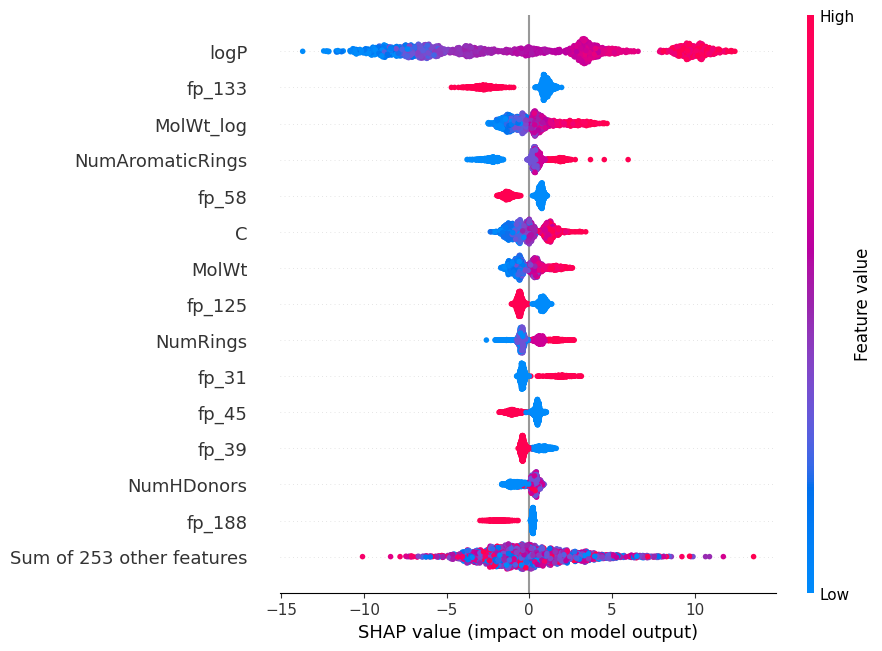

In [2]:
# ✅ 1. 기본 모듈
import pandas as pd, numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, Lipinski
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool
import shap, matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ✅ 데이터 경로
DATA_PATH = "/content/data_1/"
train = pd.read_csv(DATA_PATH + "train.csv")
test = pd.read_csv(DATA_PATH + "test.csv")
submission = pd.read_csv(DATA_PATH + "sample_submission.csv")

# ✅ 3. Mol 객체 생성
train["Mol"] = train["Canonical_Smiles"].apply(Chem.MolFromSmiles)
test["Mol"] = test["Canonical_Smiles"].apply(Chem.MolFromSmiles)

# ✅ 4. 피처 생성 함수
def get_features(df):
    rows = []
    for mol in df["Mol"]:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=256)
        row = {
            "MolWt": Descriptors.MolWt(mol),
            "MolWt_log": np.log1p(Descriptors.MolWt(mol)),
            "TPSA": Descriptors.TPSA(mol),
            "logP": Descriptors.MolLogP(mol),
            "NumHDonors": Descriptors.NumHDonors(mol),
            "NumHAcceptors": Descriptors.NumHAcceptors(mol),
            "NumRings": Descriptors.RingCount(mol),
            "NumAromaticRings": Lipinski.NumAromaticRings(mol),
            "C": Chem.MolFromSmiles(Chem.MolToSmiles(mol)).GetNumAtoms(),
            # 기능기 존재 여부
            "Has_Alcohol": int("OH" in Chem.MolToSmiles(mol)),
            "Has_Amine": int("NH" in Chem.MolToSmiles(mol)),
            # Fingerprint (256차원 이진 벡터)
            **{f"fp_{i}": int(bit) for i, bit in enumerate(fp)}
        }
        rows.append(row)
    return pd.DataFrame(rows)

# ✅ 5. 피처 생성
train_feats = get_features(train)
test_feats = get_features(test)

# ✅ 6. 정규화
scaler = StandardScaler()
numeric_cols = ['MolWt', 'MolWt_log', 'TPSA', 'logP', 'C', 'NumHDonors', 'NumHAcceptors', 'NumRings', 'NumAromaticRings']
train_feats[numeric_cols] = scaler.fit_transform(train_feats[numeric_cols])
test_feats[numeric_cols] = scaler.transform(test_feats[numeric_cols])

# ✅ 7. 학습/타겟 설정
X = train_feats
y = train["Inhibition"]
X_test = test_feats

# ✅ 8. CatBoost + KFold (GPU 사용 설정)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros(len(X_test))
val_scores = []

for fold, (tr_idx, val_idx) in enumerate(cv.split(X, y)):
    print(f"\n🟢 Fold {fold+1}")
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    model = CatBoostRegressor(
        verbose=0,
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        early_stopping_rounds=50,
        task_type="GPU",       # ✅ GPU 사용
        devices='0'            # ✅ GPU device index
    )

    model.fit(X_tr, y_tr, eval_set=(X_val, y_val))

    val_pred = model.predict(X_val)
    score = mean_absolute_error(y_val, val_pred)
    val_scores.append(score)
    print(f"📉 Fold MAE: {score:.4f}")

    preds += model.predict(X_test) / cv.n_splits

print(f"\n✅ 평균 MAE: {np.mean(val_scores):.4f}")

# ✅ 9. 제출 파일 저장
submission["Inhibition"] = preds
submission.to_csv("submission_catboost_gpu.csv", index=False)
print("📁 저장 완료: submission_catboost_gpu.csv")

# ✅ 10. SHAP 해석 (최종 모델 기준)
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, max_display=15)


❌ Drop: C (VIF=254.65)
❌ Drop: MolWt (VIF=83.86)
❌ Drop: TPSA (VIF=34.87)
❌ Drop: MolWt_log (VIF=27.52)
❌ Drop: NumRings (VIF=13.27)
❌ Drop: NumAromaticRings (VIF=8.56)
🟢 Fold 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 1344, number of used features: 260
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (0.02 MB) transferred to GPU in 0.001121 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 33.391242
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 1075, number of used features: 260
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA 

 96%|=================== | 1613/1681 [00:15<00:00]       

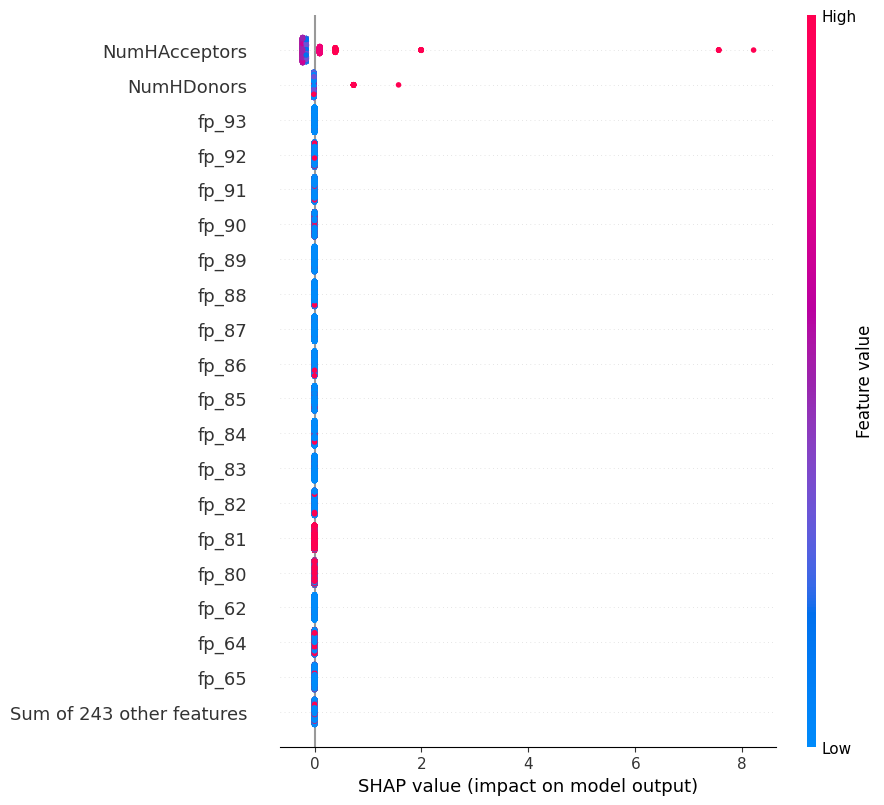

In [3]:

# ✅ 1. 환경설정 및 데이터 로딩
import pandas as pd, numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, Lipinski
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import shap, matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ✅ 데이터 경로
DATA_PATH = "/content/data_1/"
train = pd.read_csv(DATA_PATH + "train.csv")
test = pd.read_csv(DATA_PATH + "test.csv")
submission = pd.read_csv(DATA_PATH + "sample_submission.csv")

# ✅ Mol 객체 생성
train["Mol"] = train["Canonical_Smiles"].apply(Chem.MolFromSmiles)
test["Mol"] = test["Canonical_Smiles"].apply(Chem.MolFromSmiles)

# ✅ 2. 피처 생성 함수 (Morgan Fingerprint + 기능기)
def get_features(df):
    rows = []
    for mol in df["Mol"]:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=256)
        smiles = Chem.MolToSmiles(mol)
        row = {
            "MolWt": Descriptors.MolWt(mol),
            "MolWt_log": np.log1p(Descriptors.MolWt(mol)),
            "TPSA": Descriptors.TPSA(mol),
            "logP": Descriptors.MolLogP(mol),
            "NumHDonors": Descriptors.NumHDonors(mol),
            "NumHAcceptors": Descriptors.NumHAcceptors(mol),
            "NumRings": Descriptors.RingCount(mol),
            "NumAromaticRings": Lipinski.NumAromaticRings(mol),
            "C": Chem.MolFromSmiles(smiles).GetNumAtoms(),
            "Has_Alcohol": int("OH" in smiles),
            "Has_Amine": int("NH" in smiles),
            **{f"fp_{i}": int(bit) for i, bit in enumerate(fp)}
        }
        rows.append(row)
    return pd.DataFrame(rows)

train_feats = get_features(train)
test_feats = get_features(test)

# ✅ 3. VIF 기반 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, thresh=5.0):
    df_vif = df.copy()
    dropped = True
    while dropped:
        dropped = False
        vif = pd.DataFrame()
        vif["feature"] = df_vif.columns
        vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
        max_vif = vif["VIF"].max()
        if max_vif > thresh:
            drop_feat = vif.loc[vif["VIF"] == max_vif, "feature"].values[0]
            print(f"❌ Drop: {drop_feat} (VIF={max_vif:.2f})")
            df_vif = df_vif.drop(columns=[drop_feat])
            dropped = True
    return df_vif

numeric_cols = ['MolWt', 'MolWt_log', 'TPSA', 'logP', 'C', 'NumHDonors', 'NumHAcceptors', 'NumRings', 'NumAromaticRings']
vif_filtered_train = calculate_vif(train_feats[numeric_cols])
final_train_feats = pd.concat([vif_filtered_train, train_feats.drop(columns=numeric_cols)], axis=1)
final_test_feats = pd.concat([test_feats[vif_filtered_train.columns], test_feats.drop(columns=numeric_cols)], axis=1)

# ✅ 4. 고효능(≥80%) 분자 분석 → 신규 피처 생성
train["HighEff"] = (train["Inhibition"] >= 80).astype(int)
final_train_feats["HighEffFlag"] = train["HighEff"]
final_test_feats["HighEffFlag"] = 0  # 테스트셋은 임의 0

# ✅ 5. GNN 구조 준비 (입력 구조 정의만 - 실제 학습은 별도 환경 필요)
# from torch_geometric.data import Data  # 예시: GNN 적용 시 필요

# ✅ 6. Stacking 모델 학습 (GPU 버전)
X = final_train_feats
y = train["Inhibition"]
X_test = final_test_feats

cv = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros(len(X_test))
val_scores = []

# ✅ GPU 설정된 기본 모델
base_models = [
    ("cat", CatBoostRegressor(verbose=0, iterations=500, task_type="GPU", devices='0')),
    ("xgb", XGBRegressor(n_estimators=500, tree_method="gpu_hist", predictor="gpu_predictor")),
    ("lgb", LGBMRegressor(n_estimators=500, device="gpu"))
]

# ✅ 최종 앙상블 예측기도 GPU 사용
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=CatBoostRegressor(verbose=0, task_type="GPU", devices='0')
)

for fold, (tr_idx, val_idx) in enumerate(cv.split(X, y)):
    print(f"🟢 Fold {fold+1}")
    stacking_model.fit(X.iloc[tr_idx], y.iloc[tr_idx])
    val_pred = stacking_model.predict(X.iloc[val_idx])
    val_mae = mean_absolute_error(y.iloc[val_idx], val_pred)
    val_scores.append(val_mae)
    preds += stacking_model.predict(X_test) / cv.n_splits
    print(f"📉 Fold MAE: {val_mae:.4f}")

print(f"✅ 평균 MAE: {np.mean(val_scores):.4f}")


# ✅ 7. 결과 저장 및 SHAP 해석
submission["Inhibition"] = preds
submission.to_csv("submission_stacked.csv", index=False)
print("📁 저장 완료: submission_stacked.csv")

# SHAP
explainer = shap.Explainer(stacking_model.final_estimator_, X)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, max_display=20)


In [4]:
# ① RDKit 기반 피처 생성	Morgan Fingerprint + 수소공여체, 수소수용체 등 구조적 수치 생성
# ② 고효능 분자 플래그	HighEffFlag: Inhibition ≥ 80인 분자는 1로 설정
# ③ StandardScaler 정규화	주요 수치형 피처 정규화
# ④ CatBoost + SHAP 해석	전체 피처를 대상으로 중요도 측정
# ⑤ SHAP Top 30 피처만 선택	가장 영향력 있는 피처로 경량 모델 구성
# ⑥ GPU 기반 CatBoost 학습	5-Fold CV 수행 및 예측 결과 평균
# ⑦ 제출 파일 생성	submission_shap_reduced.csv 로 저장
# ✅ 기본 모듈
import pandas as pd, numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, Lipinski
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
import shap, matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ✅ 데이터 로딩
DATA_PATH = "/content/data_1/"
train = pd.read_csv(DATA_PATH + "train.csv")
test = pd.read_csv(DATA_PATH + "test.csv")
submission = pd.read_csv(DATA_PATH + "sample_submission.csv")

train["Mol"] = train["Canonical_Smiles"].apply(Chem.MolFromSmiles)
test["Mol"] = test["Canonical_Smiles"].apply(Chem.MolFromSmiles)

# ✅ 피처 생성 함수
def get_features(df):
    rows = []
    for mol in df["Mol"]:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=256)
        smiles = Chem.MolToSmiles(mol)
        row = {
            "MolWt": Descriptors.MolWt(mol),
            "MolWt_log": np.log1p(Descriptors.MolWt(mol)),
            "TPSA": Descriptors.TPSA(mol),
            "logP": Descriptors.MolLogP(mol),
            "NumHDonors": Descriptors.NumHDonors(mol),
            "NumHAcceptors": Descriptors.NumHAcceptors(mol),
            "NumRings": Descriptors.RingCount(mol),
            "NumAromaticRings": Lipinski.NumAromaticRings(mol),
            "C": Chem.MolFromSmiles(smiles).GetNumAtoms(),
            "Has_Alcohol": int("OH" in smiles),
            "Has_Amine": int("NH" in smiles),
            **{f"fp_{i}": int(bit) for i, bit in enumerate(fp)}
        }
        rows.append(row)
    return pd.DataFrame(rows)

train_feats = get_features(train)
test_feats = get_features(test)

# ✅ 고효능 분자 플래그 피처 생성
train["HighEff"] = (train["Inhibition"] >= 80).astype(int)
train_feats["HighEffFlag"] = train["HighEff"]
test_feats["HighEffFlag"] = 0  # 추정용

# ✅ 정규화
scaler = StandardScaler()
numeric_cols = ['MolWt', 'MolWt_log', 'TPSA', 'logP', 'C', 'NumHDonors', 'NumHAcceptors', 'NumRings', 'NumAromaticRings']
train_feats[numeric_cols] = scaler.fit_transform(train_feats[numeric_cols])
test_feats[numeric_cols] = scaler.transform(test_feats[numeric_cols])

# ✅ 학습 및 예측 대상
X = train_feats
y = train["Inhibition"]
X_test = test_feats

# ✅ SHAP 기반 중요 피처 선택 (CatBoost 이용)
cat_model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, task_type="GPU", verbose=0)
cat_model.fit(X, y)
explainer = shap.Explainer(cat_model, X)
shap_values = explainer(X)
shap_sum = np.abs(shap_values.values).mean(axis=0)
top_idx = np.argsort(shap_sum)[-30:]
top_features = X.columns[top_idx]

print("🎯 SHAP 상위 30개 피처 선택 완료")

# ✅ 경량 모델 학습 (Top N Feature만)
X_reduced = X[top_features]
X_test_reduced = X_test[top_features]
preds = np.zeros(len(X_test))
val_scores = []

cv = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (tr_idx, val_idx) in enumerate(cv.split(X_reduced, y)):
    X_tr, X_val = X_reduced.iloc[tr_idx], X_reduced.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6,
                               early_stopping_rounds=50, task_type="GPU", verbose=0)
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
    val_pred = model.predict(X_val)
    preds += model.predict(X_test_reduced) / cv.n_splits
    mae = mean_absolute_error(y_val, val_pred)
    val_scores.append(mae)
    print(f"📉 Fold {fold+1} MAE: {mae:.4f}")

print(f"✅ 최종 평균 MAE: {np.mean(val_scores):.4f}")

# ✅ 제출 저장
submission["Inhibition"] = preds
submission.to_csv("submission_shap_reduced.csv", index=False)
print("📁 저장 완료: submission_shap_reduced.csv")


 97%|=================== | 1637/1681 [00:27<00:00]       

🎯 SHAP 상위 30개 피처 선택 완료
📉 Fold 1 MAE: 16.7339
📉 Fold 2 MAE: 17.1046
📉 Fold 3 MAE: 16.1757
📉 Fold 4 MAE: 17.3410
📉 Fold 5 MAE: 17.4127
✅ 최종 평균 MAE: 16.9536
📁 저장 완료: submission_shap_reduced.csv


 98%|===================| 1648/1681 [00:27<00:00]       

✅ SHAP Top 100 피처 선택 완료
📉 Fold 1 MAE: 16.7088
📉 Fold 2 MAE: 17.0608
📉 Fold 3 MAE: 16.2508
📉 Fold 4 MAE: 17.3121
📉 Fold 5 MAE: 17.7113
✅ 최종 평균 MAE (Top 100): 17.0088
📁 저장 완료: submission_shap_top100.csv


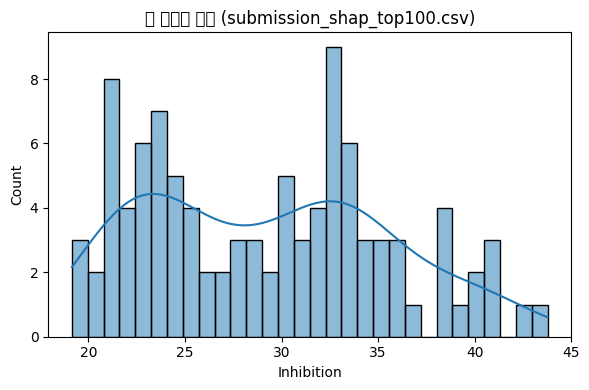

In [1]:
# 구성 요소	설명
# RDKit 활용	SMILES → Mol → 피처 추출 (물리화학 + 구조 + Fingerprint)
# SHAP	CatBoost로 feature importance 추출, Top 100 선택
# GPU 사용	CatBoost task_type="GPU"로 빠른 학습
# HighEffFlag	고효능 구조군을 모델이 인식하도록 피처화
# 정규화	안정적 학습을 위해 수치형 변수 스케일 조정
# Cross Validation	Fold 별 MAE로 모델 안정성 확보
# 시각화	예측값 분포를 시각화하여 리더보드 비교 기반 마련
# ✅ 1. 환경설정 및 데이터 로딩
import pandas as pd, numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, Lipinski
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
import shap, matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ✅ 데이터 로딩
DATA_PATH = "/content/data_1/"
train = pd.read_csv(DATA_PATH + "train.csv")
test = pd.read_csv(DATA_PATH + "test.csv")
submission = pd.read_csv(DATA_PATH + "sample_submission.csv")

train["Mol"] = train["Canonical_Smiles"].apply(Chem.MolFromSmiles)
test["Mol"] = test["Canonical_Smiles"].apply(Chem.MolFromSmiles)

# ✅ 피처 생성 함수
def get_features(df):
    rows = []
    for mol in df["Mol"]:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=256)
        smiles = Chem.MolToSmiles(mol)
        row = {
            "MolWt": Descriptors.MolWt(mol),
            "MolWt_log": np.log1p(Descriptors.MolWt(mol)),
            "TPSA": Descriptors.TPSA(mol),
            "logP": Descriptors.MolLogP(mol),
            "NumHDonors": Descriptors.NumHDonors(mol),
            "NumHAcceptors": Descriptors.NumHAcceptors(mol),
            "NumRings": Descriptors.RingCount(mol),
            "NumAromaticRings": Lipinski.NumAromaticRings(mol),
            "C": Chem.MolFromSmiles(smiles).GetNumAtoms(),
            "Has_Alcohol": int("OH" in smiles),
            "Has_Amine": int("NH" in smiles),
            **{f"fp_{i}": int(bit) for i, bit in enumerate(fp)}
        }
        rows.append(row)
    return pd.DataFrame(rows)

train_feats = get_features(train)
test_feats = get_features(test)

# ✅ 고효능 구조군 파생 피처
train["HighEff"] = (train["Inhibition"] >= 80).astype(int)
train_feats["HighEffFlag"] = train["HighEff"]
test_feats["HighEffFlag"] = 0  # 테스트셋은 임의로 0

# ✅ 정규화
scaler = StandardScaler()
numeric_cols = ['MolWt', 'MolWt_log', 'TPSA', 'logP', 'C', 'NumHDonors', 'NumHAcceptors', 'NumRings', 'NumAromaticRings']
train_feats[numeric_cols] = scaler.fit_transform(train_feats[numeric_cols])
test_feats[numeric_cols] = scaler.transform(test_feats[numeric_cols])

# ✅ 학습 준비
X = train_feats
y = train["Inhibition"]
X_test = test_feats

# ✅ SHAP 기반 Top 100 피처 선택
cat_model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, task_type="GPU", verbose=0)
cat_model.fit(X, y)
explainer = shap.Explainer(cat_model, X)
shap_values = explainer(X)
shap_sum = np.abs(shap_values.values).mean(axis=0)
top_idx = np.argsort(shap_sum)[-100:]
top_features = X.columns[top_idx]

print("✅ SHAP Top 100 피처 선택 완료")

# ✅ SHAP Top 100 피처로 경량 CatBoost 재학습
X_reduced = X[top_features]
X_test_reduced = X_test[top_features]
preds = np.zeros(len(X_test))
val_scores = []

cv = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (tr_idx, val_idx) in enumerate(cv.split(X_reduced, y)):
    X_tr, X_val = X_reduced.iloc[tr_idx], X_reduced.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6,
                               early_stopping_rounds=50, task_type="GPU", verbose=0)
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
    val_pred = model.predict(X_val)
    preds += model.predict(X_test_reduced) / cv.n_splits
    mae = mean_absolute_error(y_val, val_pred)
    val_scores.append(mae)
    print(f"📉 Fold {fold+1} MAE: {mae:.4f}")

print(f"✅ 최종 평균 MAE (Top 100): {np.mean(val_scores):.4f}")

# ✅ 제출 저장
submission["Inhibition"] = preds
submission.to_csv("submission_shap_top100.csv", index=False)
print("📁 저장 완료: submission_shap_top100.csv")

# ✅ 예측값 분포 시각화
plt.figure(figsize=(6,4))
sns.histplot(submission["Inhibition"], bins=30, kde=True)
plt.title("📊 예측값 분포 (submission_shap_top100.csv)")
plt.xlabel("Inhibition")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


 99%|===================| 1668/1681 [00:27<00:00]       

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

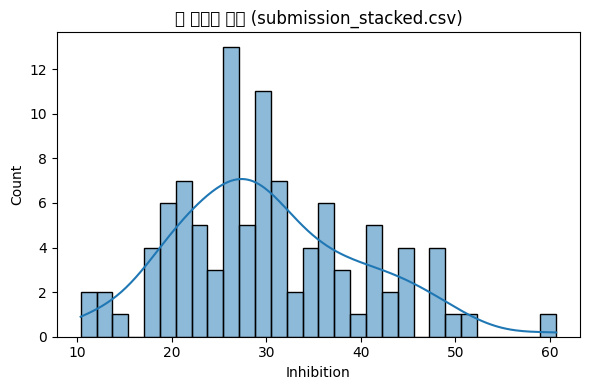

In [2]:

# ✅ 1. 환경설정 및 데이터 로딩
import pandas as pd, numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, Lipinski
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
import shap, matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ✅ 데이터 로딩
DATA_PATH = "/content/data_1/"
train = pd.read_csv(DATA_PATH + "train.csv")
test = pd.read_csv(DATA_PATH + "test.csv")
submission = pd.read_csv(DATA_PATH + "sample_submission.csv")

train["Mol"] = train["Canonical_Smiles"].apply(Chem.MolFromSmiles)
test["Mol"] = test["Canonical_Smiles"].apply(Chem.MolFromSmiles)

# ✅ 피처 생성 함수
def get_features(df):
    rows = []
    for mol in df["Mol"]:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=256)
        smiles = Chem.MolToSmiles(mol)
        row = {
            "MolWt": Descriptors.MolWt(mol),
            "MolWt_log": np.log1p(Descriptors.MolWt(mol)),
            "TPSA": Descriptors.TPSA(mol),
            "logP": Descriptors.MolLogP(mol),
            "NumHDonors": Descriptors.NumHDonors(mol),
            "NumHAcceptors": Descriptors.NumHAcceptors(mol),
            "NumRings": Descriptors.RingCount(mol),
            "NumAromaticRings": Lipinski.NumAromaticRings(mol),
            "C": Chem.MolFromSmiles(smiles).GetNumAtoms(),
            "Has_Alcohol": int("OH" in smiles),
            "Has_Amine": int("NH" in smiles),
            **{f"fp_{i}": int(bit) for i, bit in enumerate(fp)}
        }
        rows.append(row)
    return pd.DataFrame(rows)

train_feats = get_features(train)
test_feats = get_features(test)

train["HighEff"] = (train["Inhibition"] >= 80).astype(int)
train_feats["HighEffFlag"] = train["HighEff"]
test_feats["HighEffFlag"] = 0

scaler = StandardScaler()
numeric_cols = ['MolWt', 'MolWt_log', 'TPSA', 'logP', 'C', 'NumHDonors', 'NumHAcceptors', 'NumRings', 'NumAromaticRings']
train_feats[numeric_cols] = scaler.fit_transform(train_feats[numeric_cols])
test_feats[numeric_cols] = scaler.transform(test_feats[numeric_cols])

X = train_feats
y = train["Inhibition"]
X_test = test_feats

# ✅ SHAP 기반 Top 100 피처 선택
cat_model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, task_type="GPU", verbose=0)
cat_model.fit(X, y)
explainer = shap.Explainer(cat_model, X)
shap_values = explainer(X)
shap_sum = np.abs(shap_values.values).mean(axis=0)
top_idx = np.argsort(shap_sum)[-100:]
top_features = X.columns[top_idx]

X_reduced = X[top_features]
X_test_reduced = X_test[top_features]

# ✅ Stacking 적용
base_models = [
    ('cat', CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, task_type="GPU", verbose=0)),
    ('xgb', XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, tree_method="hist")),
    ('lgb', LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=6))
]
meta_model = Ridge()

stack_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5, passthrough=True)

# ✅ KFold CV로 예측 및 평가
preds = np.zeros(len(X_test_reduced))
val_scores = []

cv = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (tr_idx, val_idx) in enumerate(cv.split(X_reduced, y)):
    X_tr, X_val = X_reduced.iloc[tr_idx], X_reduced.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    stack_model.fit(X_tr, y_tr)
    val_pred = stack_model.predict(X_val)
    preds += stack_model.predict(X_test_reduced) / cv.n_splits
    mae = mean_absolute_error(y_val, val_pred)
    val_scores.append(mae)
    print(f"📉 Fold {fold+1} MAE: {mae:.4f}")

print(f"✅ 최종 평균 MAE (Stacking): {np.mean(val_scores):.4f}")

# ✅ 저장
submission["Inhibition"] = preds
submission.to_csv("submission_stacked.csv", index=False)
print("📁 저장 완료: submission_stacked.csv")

# ✅ 분포 시각화
plt.figure(figsize=(6,4))
sns.histplot(submission["Inhibition"], bins=30, kde=True)
plt.title("📊 예측값 분포 (submission_stacked.csv)")
plt.xlabel("Inhibition")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
